In [1]:
import os
import yaml

import torch
import pandas as pd
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import PyTorchModel, LUMEModule

## Load Data from BO Runs

In [2]:
data_dir = "../../data/"

files = [
    # "../optimization/optimization_results.yml",
    
    # data_dir + "20230818_LCLS_optimize/nn_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/normal_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/nn_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/turbo_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/turbo_optimization_2.yml",
    # data_dir + "20230821_LCLS_Injector/turbo_optimization_3.yml",
    
    data_dir + "20230825_LCLS_Injector/nn_optimization_vanilla.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_1.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_high_reg.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_high_reg_adj_bounds.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_low_reg_adj_bounds.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_low_reg_adj_bounds_1.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_low_reg_constraint_prior.yml",
]

In [3]:
# BO data
dfs, vocss = [], []
for filename in files:
    with open(filename) as f:
        d = yaml.safe_load(f)
    dfs.append(pd.DataFrame(d["data"]).dropna())
    vocss.append(d["vocs"])
df_all = pd.concat(dfs)
vocs = vocss[0]
len(df_all)

467

In [4]:
# check vocs consistency
all([v["variables"].keys() == vocs["variables"].keys() for v in vocss])

True

## Load NN Prior Model

In [5]:
model_path = "../lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=list(vocs["variables"].keys()),
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        # return torch.sqrt(torch.abs(sigma_x) * torch.abs(sigma_y))
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

## Load Calibrated NN Prior Models

In [6]:
calibration_path = "../../nn_prior/calibration/"

regs, cal_models = ["low", "high"], []
for reg in regs:
    # load nn_to_cal transformers
    input_nn_to_cal = torch.load(calibration_path + f"input_nn_to_cal_{reg}_reg.pt")
    output_nn_to_cal = torch.load(calibration_path + f"output_nn_to_cal_{reg}_reg.pt")
    
    # create LUME-model
    cal_lume_model = PyTorchModel(
        model_file=model_path + "model/model.pt",
        input_variables=input_variables,
        output_variables=output_variables,
        input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
        output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
    )
    
    # wrap in LUMEModule
    cal_lume_module = LUMEModule(
        model=cal_lume_model,
        feature_order=list(vocs["variables"].keys()),
        output_order=cal_lume_model.outputs[0:2],
    )
    
    cal_models.append(ObjectiveModel(cal_lume_module))

## Correlations and MAEs for Individual Runs

In [7]:
# define calculation of correlation
def calc_corr(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    corr = torch.corrcoef(torch.stack([a.squeeze(), b.squeeze()]))
    return corr[0, 1]

In [8]:
# define calculation of MAE
def calc_mae(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.l1_loss(a, b)

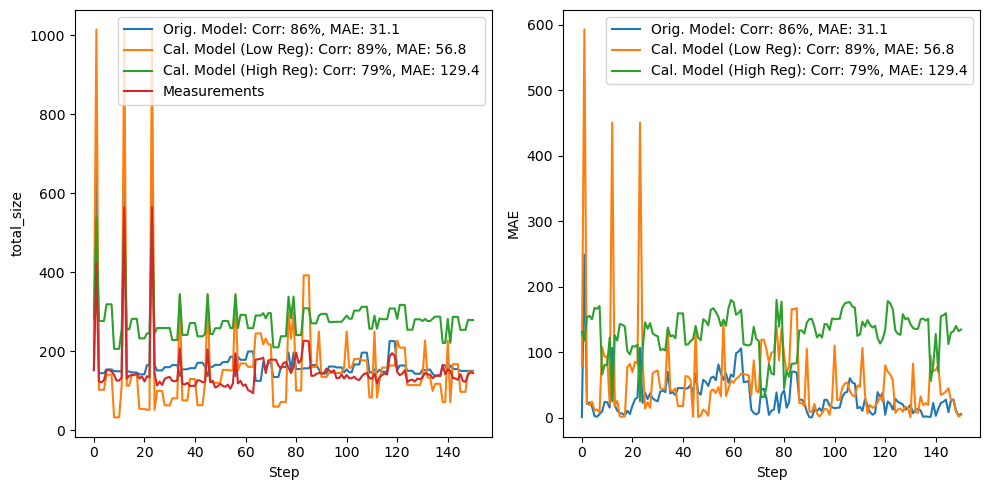

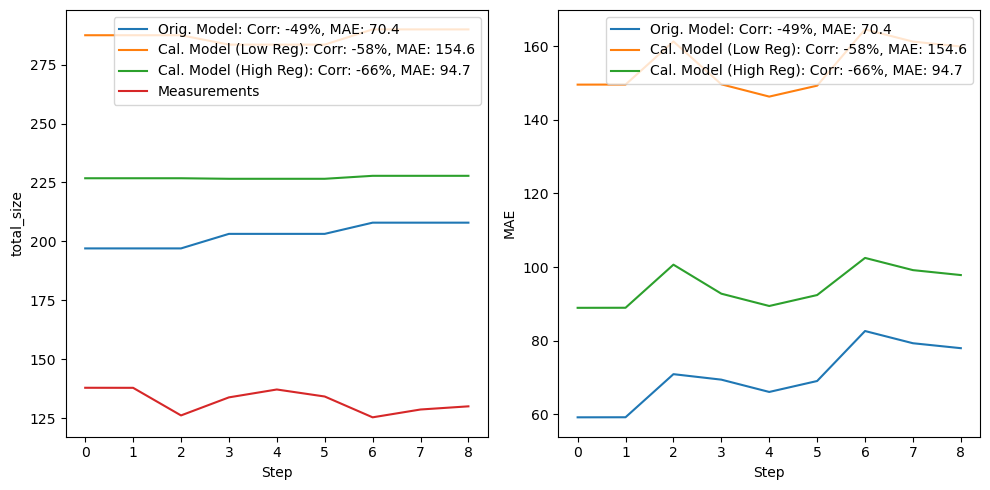

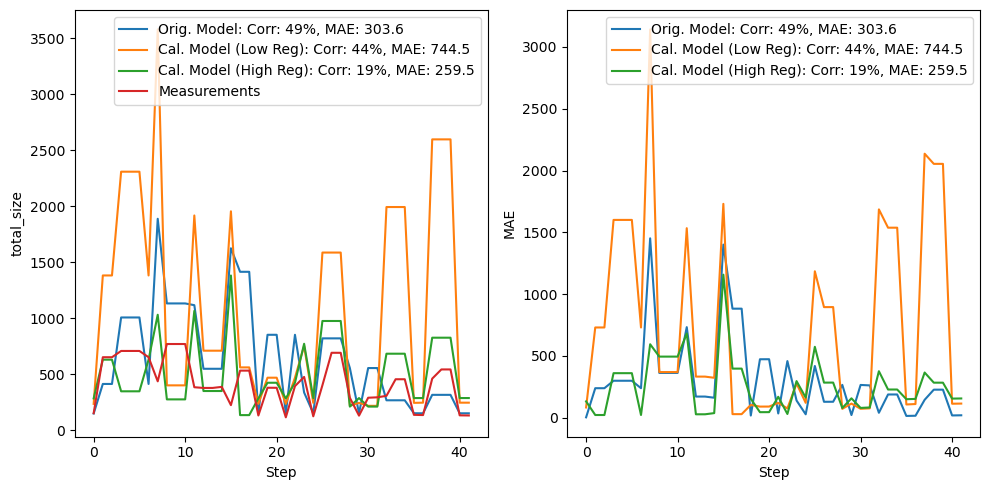

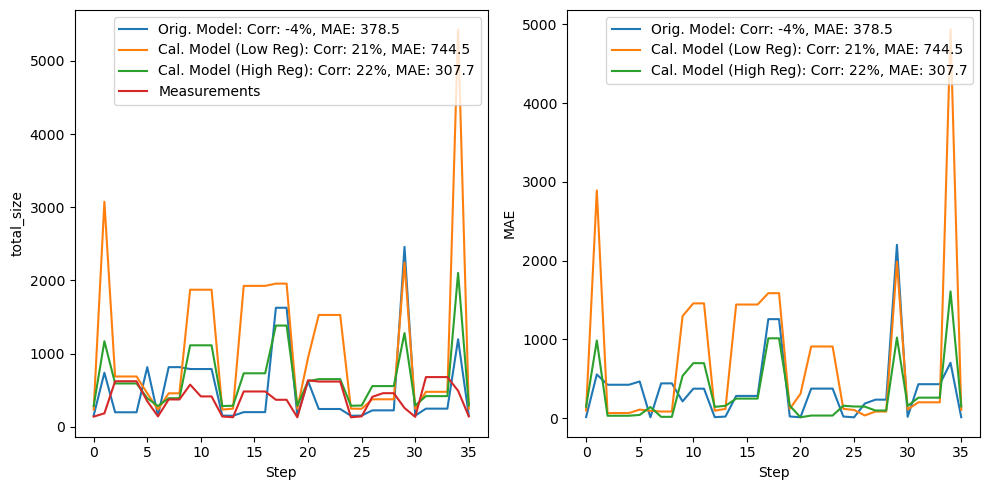

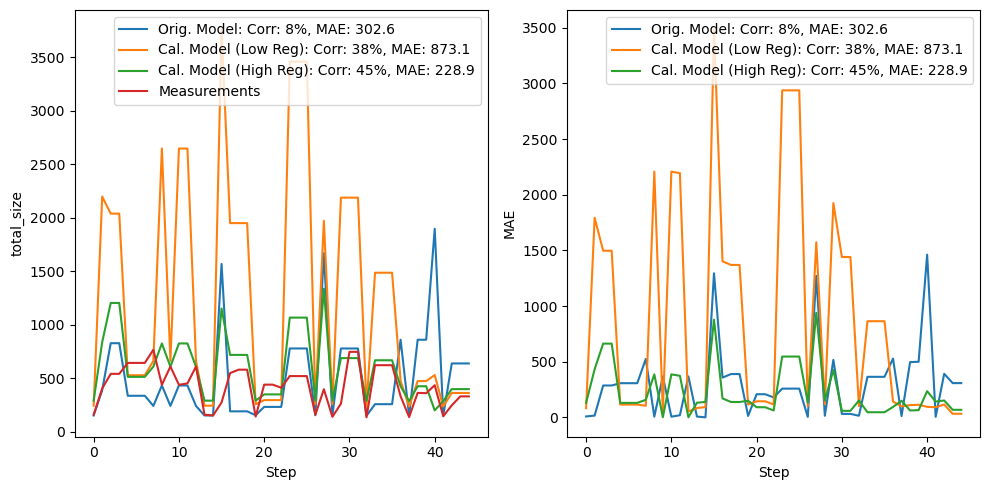

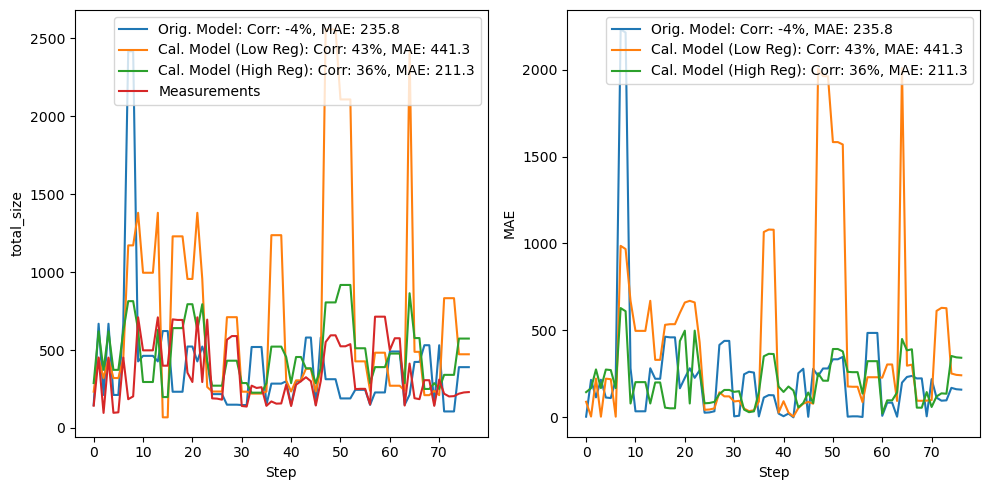

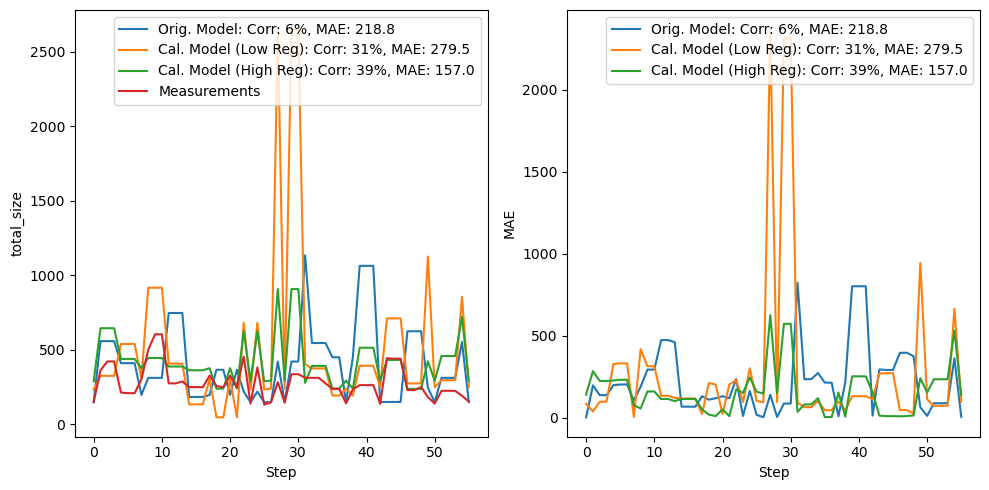

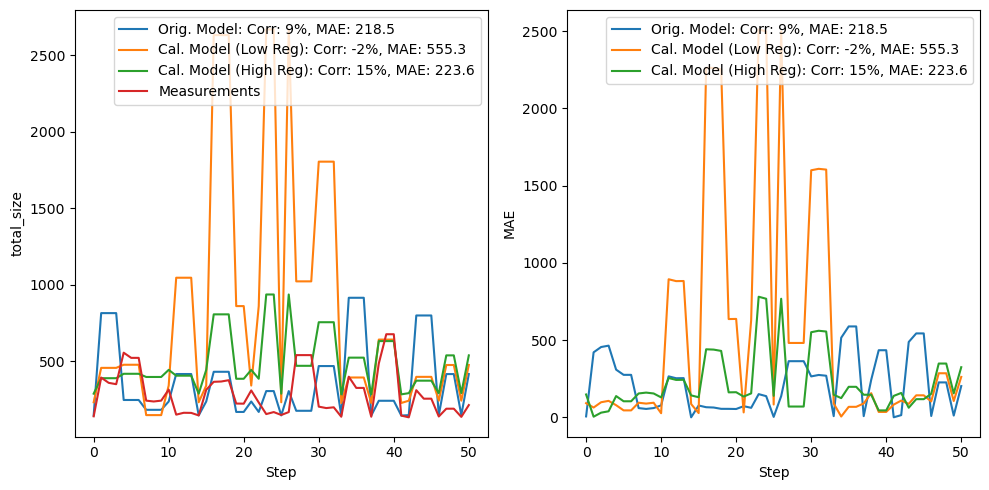

In [9]:
for i, file in enumerate(files):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    df = dfs[i]
    x = torch.from_numpy(df[lume_module.feature_order].to_numpy())
    y = torch.from_numpy(df[list(vocs["objectives"].keys())[0]].to_numpy())

    predictions, errors = [], []
    correlations, maes = [], []
    for model in [objective_model] + cal_models:
        pred = model(x)
        predictions.append(pred)
        errors.append(torch.abs(pred - y))
        correlations.append(calc_corr(pred, y).item())
        maes.append(calc_mae(pred, y).item())

    axis = torch.arange(len(errors[0]))
    labels = ["Orig. Model", "Cal. Model (Low Reg)", "Cal. Model (High Reg)"]
    for j in range(len(labels)):
        ax[0].plot(axis, predictions[j], label="{}: Corr: {:.0f}%, MAE: {:.1f}".format(labels[j], 1e2 * correlations[j], maes[j]))
    ax[0].plot(axis, y, label="Measurements")
    ax[0].set_xlabel("Step")
    ax[0].set_ylabel("total_size")
    ax[0].legend(loc="upper right")

    for j in range(len(labels)):
        ax[1].plot(axis, errors[j], label="{}: Corr: {:.0f}%, MAE: {:.1f}".format(labels[j], 1e2 * correlations[j], maes[j]))
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel("MAE")
    ax[1].legend(loc="upper right")

    fig.tight_layout()

## Correlations and MAEs for All Data

In [10]:
metrics = pd.DataFrame(columns=["Corr", "MAE"])
for model in [objective_model] + cal_models:
    model_metrics = []

    # inputs and targets
    x = torch.from_numpy(df_all[lume_module.feature_order].to_numpy())
    y = torch.from_numpy(df_all[list(vocs["objectives"].keys())[0]].to_numpy())
    
    # predictions
    pred = model(x)
        
    # compute model metrics
    model_metrics.append("{:.2f}".format(calc_corr(pred, y).item()))
    model_metrics.append("{:.2f}".format(calc_mae(pred, y).item()))

    metrics.loc[len(metrics.index)] = model_metrics
metrics.index = ["Original Model", "Calibrated (Low Reg)", "Calibrated (High Reg)"]

In [11]:
metrics

,Corr,MAE
Original Model,0.35,186.05
Calibrated (Low Reg),0.52,396.74
Calibrated (High Reg),0.50,190.84
